<a href="https://colab.research.google.com/github/ThomasGesseyJones/DARA_21cm_Signal_Simulation/blob/development/DARA_21cm_Signal_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DARA 21-cm Signal Simulation


In this notebook, we'll create a simple simulation of the 21-cm signal together. We shall implement the key physics we learnt in the theory lectures earlier and produce our own predictions for what the 21-cm global signal and power spectrum may look like.

If you haven't already found it this notebook is hosted on GitHub at
[https://github.com/ThomasGesseyJones/DARA_21cm_Signal_Simulation](https://github.com/ThomasGesseyJones/DARA_21cm_Signal_Simulation)

In the repository, there is also a short README.md (and a setup pdf) on how to get your own copy of this notebook on your google account so you can follow along and experiment!

## A Quick Introduction to Google Colab/Jupyter Notebooks

TOOD

## Types of 21-cm Signal Simulation

Before we start we need to decide what type of 21-cm signal simulation we are going to create. Broadly speaking we can split 21-cm signal simulations into three categories:
- Analytic
- Numeric 
- Semi-numerical 

**Analytic** simulations (e.g. TODO) typically operate by solving the differential equations that describe the 21-cm signal's evolution under the assumption of a homogeneous universe. So they treat the 21-cm signal $T_{\rm 21}$ at a given redshift $z$ and all things it depends upon, such as the kinetic temperature $T_{\rm K}$ and electron fraction $x_{\rm e}$, as having the same value throughout the entire universe. This has the advantage that for each of these quantities at each redshift step you only need to store one number, so it requires very little memory. In addition, because radiative transfer does not need to be modelled solving the differential equations is computationally easy, leading to very quick codes. In reality, of course, the 21-cm signal is not uniform. Assuming so means you cannot make predictions for the 21-cm power spectrum, and your predictions of the global 21-cm signal are potentially biased. Hence, analytic simulations are great for theoretic studies but are not always accurate enough for your purpose.

**Numeric** simulations (e.g. TODO) are the opposite extreme. They use particle hydrodynamics codes to model the evolution of large portions of the universe. Physics modelled in these simulations often includes dark matter and baryons collapsing into halos under gravity, chemical and thermal evolution of the gas, star formation, and radiative transfer. As star formation occurs on much smaller scales (parsecs) than the cosmological volumes of interest (Megaparsecs or Gigaparsecs) these simulations require billions of particles to get sufficient resolution. Consequently, they are hugely computationally expensive. For example, the [CoDa II](https://arxiv.org/abs/1811.11192) simulations ran on the Titan supercomputer using 16384 GPUs and 65536 cores. This means the number of such simulations that can be done is limited, though they do provide the most accurate simulations we can achieve. 

**Semi-numerical** simulations (e.g. TODO) are somewhat of a compromise between the previous two methods. They aim to be physically realistic enough to produce accurate predictions of the 21-cm signal, including its spatial variations, but fast and low-memory enough to be run on a commercially available desktop computer. This is typically achieved by splitting the cosmological volume into smaller simulation cells typically each a few comoving Megaparsecs in size. The cells can have different temperatures, ionization fractions, 21-cm signals, etc... and hence allow for the variation in the 21-cm signal to be modelled. Physics below the size of the cell, e.g. star formation, is treated using analytic approximations, while large-scale physics that goes between cells, e.g. radiative transfer, is treated numerically. Hence, the name semi-numerical. 

Since we want accurate enough predictions in a reasonable time frame (ideally the hour length of this session) we shall develop a simple semi-numerical simulation code. 

##Representing the Universe

As mentioned above we are going to split our simulation of the universe into $N \times N \times N$ pixels each with some sidelength $L_{\rm pix}$. Prior wisdom shows $L_{\rm pix} = 3$ comoving Megaparsecs is a good choice, and our $N$ will be limited to 64 by our computational resources (128 or larger would be ideal). 

In case, you haven't seen it before comoving lengths are distances that scale with the expansion of the universe. So 3 comoving Megaparsecs (abbreviated to 3 cMpc) means the pixel would be 3 Megaparsecs in physical length today, but it would have been 0.3 Megaparsec in physical size at redshift $9$ when the universe was a tenth of its current size. We choose to have our cells be defined in comoving Megaparsecs so they, and our simulation box, scale automatically with the expansion of the universe. 

Let us start then by defining these all-important quantities as constants for our simulation

In [1]:
L_PIX = 3   # Pixel size in cMpc
N_PIX = 64  # Number of pixels on each side of the simulation cube (kept small due to RAM and runtime limitations)

Now we have the space of our simulation sorted, let us think about the time variable. In general, time is a pain to work with in cosmology because it is specific to the exact cosmological parameters you are using, and isn't a direct observable. Instead, it is more common to work in redshift $z$. Hence that is what we shall do too. For simplicity we shall hardcode our simulation to run from redshift $50$ to $6$ (roughly the end of reionization when $T_{\rm 21}$ vanishes) in steps of size 1

In [2]:
import numpy as np
ZS_SIM = np.arange(50, 5, -1)  # Redshift 'time'-steps of our simulation
print(ZS_SIM)

[50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6]


One last thing to mention, to ensure that our simulation does not depend on things outside of our simulation box we shall be using periodic boundary conditions throughout our implementation. 

## Algorithm Overview

Before we go any further let us think about our end goal so we focus on writing the code we need to achieve it. We wish to compute the 21-cm signal $T_{\rm 21}$ throughout our simulation cube at different redshifts. As we established in the theory lecture earlier to do this we need to know the
- Background radiation temperature $T_{\gamma}$
- IGM kinetic temperature $T_{\rm K}$
- Neutral fraction of the IGM $x_{\rm HI}$ or equivalently the electron fraction $x_{\rm e}$
- IGM hydrogen density $n_{\rm H}$
- and Lyman-$\alpha$ intensity $J_{\rm \alpha}$, so that we can calculate the coupling of the spin temperature $T_{\rm S}$ to $T_{\rm K}$

In our simulations, we will not include any excess radio background, so we can take $T_{\gamma}$ to just be the CMB temperature everywhere (the fluctuations in the CMB are too small to be important to us)

In [3]:
T_CMB_0 = 2.725  # K
def temperature_background_radiation(redshift):
    """ Calculates background 21-cm radiation temperature at a given redshift """
    return T_CMB_0*(1 + redshift)

The other four quantities of interest vary between different locations in our simulations. Hence, we shall need to model the evolution of these in more detail, finding at each redshift $N \times N \times N$ cubes of $T_{\rm K}$, $x_{\rm HI}$, $n_{\rm H}$, and $J_{\alpha}$. After starting from some initial conditions we will thus update these cubes of these four quantities in a numerical loop by:
1. Using perturbation theory to evolve the matter overdensity to the current $z$ and thus find $n_{\rm H}$
2. Employ an analytic prescription to calculate star formation rates given the current matter overdensity in a cell
3. Find the radiation fields at the current time step. For our simple simulation, these are the Lyman-$\alpha$, Ionizing photon, and X-ray radiation fields
4. Numerically integrate $T_{\rm K}$ to the current redshift
5. Numerically integrate $x_{\rm e}$ to the current redshift
6. Calculate our $T_{\rm 21}$ cube (what we want) and store it to output at the end
7. Repeat for the next redshift 

But before we implement these steps, we need somewhere to start from, the initial conditions. 

## 0. Initial Conditions

Now let us specify the initial state of the simulation at $z = 50$. Many excellent codes exist (CAMB, CLASS, RECFAST (TODO cite)) that can evolve analytically from the CMB at redshift $z \approx 1100$ down to $z = 50$, and so we shall use the outputs of these codes to set our simulations initial state


In [4]:
# At z = 50, RECFAST gives an average kinetic temperature of 72 K, we shall assume it is approximatley uniform
initial_tk = np.ones((N_PIX, N_PIX, N_PIX), dtype=float) * 72   

# At z = 50, RECFAST gives an average electron fraction 0.0005, also assumed uniform
initial_xe = np.ones((N_PIX, N_PIX, N_PIX), dtype=float) * 5e-4  

For $T_{\rm K}$ and $x_{\rm e}$ we assumed spatial uniformity, simplifying our setting of their initial conditions. However, if we set all the initial state of our simulation to be uniform then our simulation will produce a uniform $T_{\rm 21}$ signal which we know is not realistic. It turns out the key spatial variation to encompass is that in density, normally expressed in terms of overdensity $\delta$ the fractional increase in density from the cosmological mean. At $z = 50$, the matter overdensity at our simulation lengthscales is expected to be described by a Gaussian random field, with a power spectrum that we can compute with Boltzmann solver codes such as CAMB (TODO). Here we use a fitting formula to the 
that power spectrum for quicker evaluation




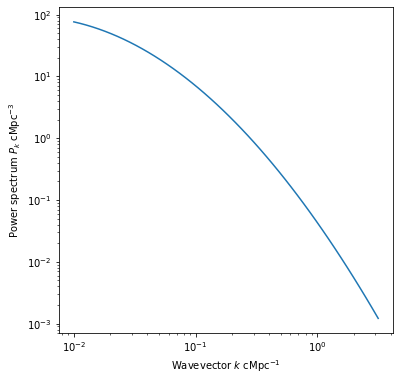

In [5]:
# Spherical overdensity power spectrum approximation
def overdensity_spherical_power_spectrum(comoving_wavevector):
    """ 
    Approximation of the matter overdensity spherically averaged power spectrum at
    z = 50. Only valid for 0.03 cMpc^-1 <= k <= 1.8 cMpc^-1. 
    
    Returns power spectrum in units of cMpc^3 at the given k.
    """
    log_ks = np.log(comoving_wavevector)   # Assumes comoving wavevector in inverse cMpc
    polynomial_fit = -0.2562 * log_ks**2 + -2.8043 * log_ks + -3.1453
    return np.exp(polynomial_fit)


# Visualize 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
plotting_ks = np.logspace(-2, .5)
ax.plot(plotting_ks, overdensity_spherical_power_spectrum(plotting_ks))
ax.set_xlabel('Wavevector $k$ cMpc$^{-1}$')
ax.set_ylabel('Power spectrum $P_k$ cMpc$^{-3}$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close(fig)

We thus want to find a Gaussian random field with the above power spectrum. The computational details of how to do this are not important to us, all we need is the end product, the cube of overdensities at redshift 50, depicted below

<ipython-input-5-0d3affe9fc52>:9: RuntimeWarning: divide by zero encountered in log
  log_ks = np.log(comoving_wavevector)   # Assumes comoving wavevector in inverse cMpc
<ipython-input-5-0d3affe9fc52>:10: RuntimeWarning: invalid value encountered in add
  polynomial_fit = -0.2562 * log_ks**2 + -2.8043 * log_ks + -3.1453


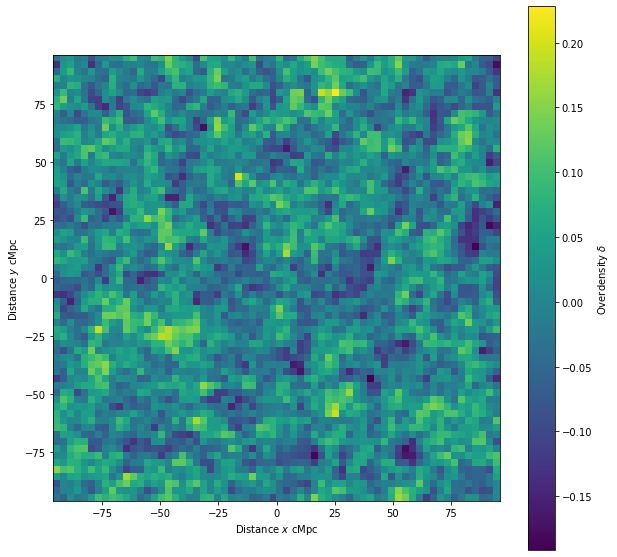

In [6]:
import scipy.fft
import scipy.fftpack


# Function to compute our Gaussian random field (you do not need to understand how this works)
def compute_gaussian_random_field(shape, spherical_power_spectrum_fn):
    """ Function to compute a gaussian random field with given power spectrum """

    # Start with a normal gaussian random field and convert to fourier space
    # this is to enforce P(k) = *P(-k) property and give us our initial randomness
    standard_gaussian_random_field = np.random.normal(0, 1, shape)
    field_in_k_space = scipy.fft.fftn(standard_gaussian_random_field)

    # Each fourier mode now is a gaussian random variable with expected square magnitude N_PIX**3. Hence, it needs to 
    # be scaled so its expected square magnitude is instead that of the spherical power spectrum at the corresponding k 

    # Find wavevectors for each point in our random field
    ks_1d = [2*np.pi*scipy.fftpack.fftfreq(N_DIM, d=L_PIX) for N_DIM in shape]
    kxs, kys, kzs = np.meshgrid(*ks_1d)
    ks = np.sqrt(kxs**2 + kys**2 + kzs**2)

    # Get corresponding power spectrum values and from that the normalization
    spherical_pk_at_ks = spherical_power_spectrum_fn(ks)
    normalizations = np.sqrt(spherical_pk_at_ks/L_PIX**3)
    normalizations[0, 0, 0] = 0  # Special case = 0 by overdensity definition  

    # Scale and return field back in real space
    scaled_field = field_in_k_space*normalizations
    return np.real(scipy.fft.ifftn(scaled_field))


# Fix random seed for reproducability 
import random
random.seed(102023)

# Get our overdensity field 
overdensity_z_50 = compute_gaussian_random_field((N_PIX, N_PIX, N_PIX), overdensity_spherical_power_spectrum)


# Depict a slice of the overdensity
fig, ax = plt.subplots(figsize=(10, 10))
image = ax.imshow(overdensity_z_50[:, :, 0], cmap='viridis', 
                  extent=[-N_PIX*L_PIX/2, N_PIX*L_PIX/2, -N_PIX*L_PIX/2, N_PIX*L_PIX/2])
cbar = fig.colorbar(image, ax=ax, label='Overdensity $\delta$')
ax.set_xlabel('Distance $x$ cMpc')
ax.set_ylabel('Distance $y$ cMpc')
plt.show()
plt.close(fig)

Lastly, due to the numerics of our simulation, we are going to need the $z = 50$ value for the star formation rate density (SFRD). We can fairly safely assume the SFRD at such a high redshift value is 0  

In [7]:
initial_sfrd = np.zeros((N_PIX, N_PIX, N_PIX), dtype=float)   

## 1. Evolving Overdensity

We now have our initial conditions all set. So we shall next work through our simulation loop, defining functions that will perform those key steps for us. The first on our list is to evolve the overdensity $\delta$ to the current redshift, and thus find the hydrogen number density $n_{\rm H}$. As we are considering large scales at high redshifts we shall assume we can treat the overdensity as always evolving via linear perturbation theory (in truth this assumption breaks down for rare peaks and troughs at the lower redshifts in our simulation). Linear perturbation theory predicts the overdensity grows as $\propto 1/(1+z)$, so we can implement this step quite simply


In [8]:
def current_overdensity_field(redshift):
    """ Calculates overdensity at a given redshift """
    # Linear perturbation theory growth
    current_overdensity = overdensity_z_50 * (1 + np.max(ZS_SIM)) / (1 + redshift)

    # Ad hoc fix to stop it going into unphysical regions in rare peaks (above critical overdensity)
    current_overdensity = np.minimum(current_overdensity, 1.686*(1-(1+redshift)/2000))  
    # or rare voids (below -1)
    current_overdensity = np.maximum(current_overdensity, -0.99)

    return current_overdensity

To convert this to the hydrogen number density $n_{\rm H}$ in each pixel, we then times by the average comoving hydrogen number density (effectively constant post recombination), and convert it into a physical density

In [9]:
def physical_nh(redshift):
    """ Calculates the hydrogen number density at a given redshift [number cMpc^-3]"""
    # Get comoving number density
    average_comoving_nh = 5.5899e+66          # From Planck in particles per comoving megaparsec 
    comoving_nh = average_comoving_nh*(1 + current_overdensity_field(redshift))

    # Correct into physical density
    return comoving_nh * (1 + redshift)**3

## 2. Star Formation Prescription 

Now we know the overdensity in each of our simulation pixels we want to convert this into a star formation rate. We shall do this in three stages. First using an analytic prescription we shall find the expected number of dark matter halos of different masses in a pixel with a given overdensity. Then we use an analytic prescription to decide which halos will form stars. Finally, we shall convert the total dark matter halo mass to a stellar mass using a star formation efficiency. 

To calculate the expected number of dark matter halos in our pixels we shall use the Sheth-Tormen (TODO cite) mass function. Thankfully, this is a very commonly used function in cosmology and so there already exists some excellent python packages that implement this function for us, such as `hmf` (TODO cite). This package does not come as standard on Google Colab so let us install it 

In [10]:
!pip install hmf
import hmf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.1 MB/s eta 0:00:00
  Created wheel for camb: filename=camb-1.3.6-py3-none-any.whl size=1063328 sha256=795490d2014d83ee98c741f64ada382a74b296cab784950849e3b409439c7222
  Stored in directory: /root/.cache/pip/wheels/bd/67/8c/7ccb547de7a94170c67cc3294f520e48451d1947bb26572bce
Successfully built camb
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency

The `hmf` package implements various halo mass functions via the `MassFunction` object. To get the cosmological halo mass function at a particular redshift, over a desired mass range, we instantiate the object with the appropriate redshift `z`, minimum halo mass `Mmin` and maximum halo mass `Mmax`. Then access the halo mass function as the `.dndm` property of the object

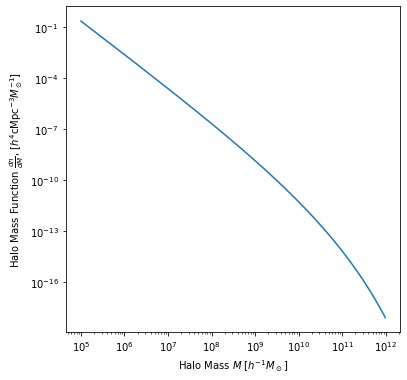

In [37]:
# Create the halo mass function object 
mf = hmf.MassFunction(z=7, Mmin=5, Mmax=12)

# Depict halo mass function 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(mf.m, mf.dndm)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Halo Mass $M$ $[h^{-1}M_\odot]$")
ax.set_ylabel(r"Halo Mass Function $\frac{dn}{dM}$ $[h^{4}{\rm cMpc}^{-3}M_\odot^{-1}]$")
plt.show()
plt.close(fig)

We can account for being in an overdense or underdense region by increasing or decreasing the sigma_8 parameter of the mass function 

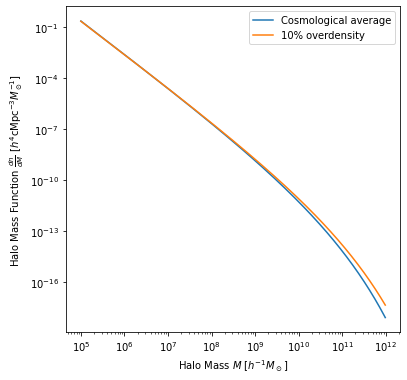

In [38]:
# Save old results (hmf does not seem to like having two different MassFunction objects in use at the same time)
average_mf_m = mf.m
average_mf_dndm = mf.dndm

# Get sigma 8 of the Planck LCDM cosmology from hmf defaults  
cosmological_sigma_8 = hmf.MassFunction.get_all_parameter_defaults(recursive=False)['sigma_8']

# Increase sigma 8 to simulate being in a 10% overdensity 
example_overdensity = 0.1
overdense_mf = hmf.MassFunction(z=7, Mmin=5, Mmax=12, sigma_8=cosmological_sigma_8*(1 + example_overdensity))

# Plot a comparison 
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(average_mf_m, average_mf_dndm, label='Cosmological average')
ax.plot(overdense_mf.m, overdense_mf.dndm, label='10% overdensity')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Halo Mass $M$ $[h^{-1}M_\odot]$")
ax.set_ylabel(r"Halo Mass Function $\frac{dn}{dM}$ $[h^{4}{\rm cMpc}^{-3}M_\odot^{-1}]$")
ax.legend()
plt.show()
plt.close(fig)

We see the expected results that in an overdense region, there are more high-mass dark matter halos. A quick word of caution `hmf` uses Hubble normalized units, which we will need to correct for as we are using unscaled units. 

On to the second step then. What halos form stars? Again we shall use a simple analytic prescription, in this case, that of Tegmark et al. 1997 (TODO). Dark matter halos form stars if they are above the critical mass threshold of 
$$
M_{\rm crit} = \left(3.3 \times 10^7 {\rm \,M}_{\odot}\right) \times (1 + z)^{-3/2}
$$


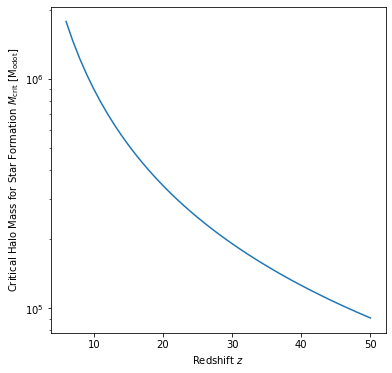

In [13]:
def critical_halo_mass_for_star_formation(redshift):
    """ Dark matter halo mass above which stars will form in the halo """
    return 3.3e7 * ((1 + redshift)**(-3/2))


# Illusration of this function 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(ZS_SIM, critical_halo_mass_for_star_formation(ZS_SIM))
ax.set_yscale('log')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"Critical Halo Mass for Star Formation $M_{\rm crit}$ [M$_{\rm odot}$]")
plt.show()
plt.close(fig)

Finally, we need to specify our star formation efficiency. We can split this into two efficiency factors, the fraction of a halos mass that is baryons $f_{\rm gas}$ and the fraction of baryons which are in stars $f_{*}$. For the former, we shall just assume the cosmological ratio holds for dark matter halos and use

In [14]:
F_GAS = 0.171

We shall treat $f_*$ in more detail than we did $f_{\rm gas}$. 

$f_*$ should vary between halos of different masses (e.g. $f_*(M)$). It is expected to be lower in smaller halos, and greater in larger halos due to feedback effects (at least for the relatively low-mass halos we are considering, AGN complicate things at higher masses). We shall model this by having a log suppression in our $f_*$ below the atomic cooling threshold $M_{\rm atm}$, the mass of dark matter halos above which star formation can occur from cooling due to atomic hydrogen alone (in smaller halos molecular hydrogen is required to cool the gas)
$$
M_{\rm atm} = \left(3.45 \times 10^8 {\rm M}_{\odot} \right) \times \left(\frac{1+z}{21}\right)^{-3/2}
$$
Above this threshold ($M > M_{\rm atm}$) we shall take $f_*$ as a constant, $f_{\rm star}$, the first of the four inputs to our simulation. While below $M_{\rm crit}$ $f_* = 0$ by definition. Hence, enforcing continuity of $f_*$ we have the star formation efficiency in halos of mass $M_{\rm crit} \leq M \leq M_{\rm atm}$ as
$$
f_*(M) = \frac{\log(M) - \log(M_{\rm crit})}{\log(M_{\rm atm}) - \log(M_{\rm crit})}f_{\rm star}
$$

In [40]:
def get_suppressed_fstar(f_star, masses, m_crit, redshift):
    """ Calculate f_star in halos of various masses """
    # We need to know the atomic cooling threshold to suppress under 
    m_atm = 3.45e8 * (((1 + redshift) / 21)**(-3/2))

    # Branchless case by-base handling for easy vectorization 
    f_star_sup = 0*(masses < m_crit) + \
                 f_star*(masses >= m_crit)*(masses <= m_atm)*(np.log(masses)   
                 - np.log(m_crit))/(np.log(m_atm) - np.log(m_crit)) + \
                 f_star*(masses > m_atm)                                       
    return f_star_sup

Let us now combine all of this into a function that compute the star formation rate density at a given redshift

In [16]:
# Scipy functions we will need for interpolation and integration 
from scipy.interpolate import interp1d
from scipy.integrate import trapz 

# Cosmological parameters (hardcoded for us)
PLANCK_h = 67.4/100
PLANCK_Omega_m = 0.315


# First get stellar mass in each pixel
def stellar_mass(redshift, f_star):
    """ Get stellar mass density in each pixel in Msol cMpc^-3 """
    
    # Current overdensity
    overdensity = current_overdensity_field(redshift)

    # Current critical mass for star formation
    m_crit = critical_halo_mass_for_star_formation(redshift)

    # For computational efficiency let us define an interpolator function to approximate the stellar mass of a cell
    # given its overdensity 

    # Start by setting what values we are going to interpolate in between
    sample_overdensities = np.linspace(np.min(overdensity), np.max(overdensity), 100)
    sample_solar_mass_densities = np.empty(sample_overdensities.shape, dtype=float)

    # Get the mass function at this redshift above the critical mass threshold (halos below aren't of interest)
    create_mass_function = hmf.MassFunction(z=redshift, Mmin=np.log10(m_crit/PLANCK_h), Mmax=np.log10(1e13/PLANCK_h))

    # Update the mass function for each overdensity (updating is more efficient as can reuse parts of calculation)
    for idx, delta in enumerate(sample_overdensities):
        create_mass_function.update(sigma_8=np.maximum(cosmological_sigma_8*(1 + delta), 0.1))  # sigma_8 >= 0.1 in hmf

        # Correct for hubble normalized units being used
        halo_masses = create_mass_function.m / PLANCK_h
        halo_mass_function = create_mass_function.dndm * PLANCK_h**4

        # Integrate to find stellar mass density in Msol cMpc^-3 (performed in ln M for better convergence)
        sup_fstar = get_suppressed_fstar(f_star, halo_masses, m_crit, redshift)
        stellar_mass_density = trapz(sup_fstar*F_GAS*(halo_masses**2)*halo_mass_function, np.log(halo_masses))

        # Store 
        sample_solar_mass_densities[idx] = stellar_mass_density
    
    # Setup the interpolator
    delta_to_solar_mass_fn = interp1d(sample_overdensities, sample_solar_mass_densities)

    # Interpolate to get the stellar mass density across our entire simulation box 
    return delta_to_solar_mass_fn(overdensity)


# Convert to star formation rate
def star_formation_rate_density(redshift, f_star):
    """ Get star formation rate density cube in Msol yr^-1 cMpc^-3 """

    # Find change in stellar mass between now and a short time (dz) ago
    dz = 1e-5
    stellar_mass_density_now = stellar_mass(redshift, f_star)
    stellar_mass_density_dz_ago = stellar_mass(redshift + dz, f_star)

    # Conver this dz to time interval dt using standard LCDM formula 
    dt = dz/ ((1 + redshift) * (PLANCK_h * 100 * np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + redshift)**3))))
    dt = dt * 3.09e19 / 3.16e7  # Convert to years

    # Calculate derivative to get SFRD
    return (stellar_mass_density_now - stellar_mass_density_dz_ago) / dt


Before we move on, let us quickly test this code works and plot the average star formation rate
density across a few redshifts

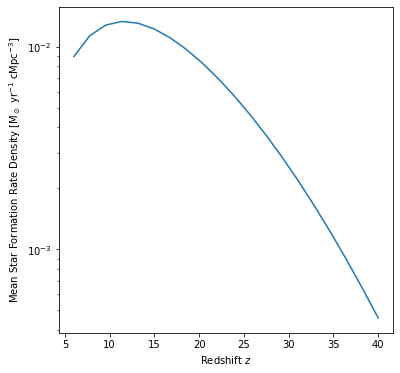

In [17]:
# Plot mean SFRD
fig, ax = plt.subplots(figsize=(6,6))

plotting_zs = np.linspace(6, 40, 20)  # What redshifts to plot
test_f_star = 0.01                    # Need a value of fstar

ax.plot(plotting_zs, [np.mean(star_formation_rate_density(z, test_f_star)) for z in plotting_zs])
ax.set_yscale('log')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"Mean Star Formation Rate Density [M$_{\rm \odot}$ yr$^{-1}$ cMpc$^{-3}$]")
plt.show()
plt.close(fig)

Normally we would not expect the star formation rate density to peak but instead, keep increasing (at least not until $z \approx 2$). This is an artefact of our oversimplified star formation model, especially us not including important feedback effects such as the Lyman-Werner feedback

## 3. Radiative Transfer

Now we have our star formation rate densities we wish to convert these to radiation fields for the key radiative species, Lyman-$\alpha$, X-rays, and Ionizing photons. 


### 3.1 Lyman-$\alpha$

Let us start with Lyman-$\alpha$. As discussed in the theory lecture Lyman band photons trigger the Wouthuysen Field Effect once redshifted or cascaded into the Lyman-$\alpha$ line so it is important to include them in our simulation. For simplicity we will make a few assumptions:
1. Lyman-$\alpha$ emission is isotropic
2. All star forming halos emit Lyman band photons with the same efficieny and spectra
3. Said spectra is flat when expressed in terms of number per unit frequency
4. We can ignore injected Lyman-$\alpha$ photons and just consider continuum Lyman-$\alpha$ photons

We make the last assumption to avoid having to introduce the full complexity of cascading modelling. We hence want to impliment a slightly modified version of the prescription introduced in Barkana and Loev 2005 (TODO cite) where the Lyman-$\alpha$ radiation field is given by the integral
$$
J_{\alpha}(\vec{x}, z) = \int_z^{z_{\rm max}} dz' \frac{1}{4 \pi} \frac{(1 + z)^2}{4 \pi r_c^2} \left\langle \frac{d \phi(\nu')}{d z} \right\rangle_{r_c} 
$$
where $r_c$ is the comoving distance a photon would travel between $z'$ and $z$, $\nu'$ the energy of a photon emitted at $z'$ that is just redshifting into the Lyman-$\alpha$ frequency
$$
\nu' = \nu_{\alpha} (1 + z')/(1+z),
$$
$z_{\rm max}$ is the maximum redshift Lyman-$\alpha$ photons could be arriving from, which for us ignoring cascading is given by any redshift for which $\nu'$ is greater than the Lyman-$\beta$ energy
$$
z_{\rm max} = \frac{\nu_{\beta}}{\nu_{\alpha}} (1+z) - 1 = \frac{32}{27}(1+z) - 1,
$$
and $\langle d \phi(\nu') / d z \rangle$ is the emissivity per unit redshift (in photons per Hz per second) at $\nu'$ at $z'$ averaged over a spherical shell of radius $r_p$. 

We shall take as a parameter of our simulation a Lyman emission efficiency $\eta_{\rm Ly}$, the number of Lyman band photon emitted per $M_{\odot}$ of star formation. Hence using our assumption of a flat Lyman band emission we get the local emissivity in the Lyman band is ,
$$
\frac{d\phi(\nu)}{d z} = \eta_{\rm Ly} {\rm SFRD} \frac{3}{\nu_{\alpha}} \frac{dV}{dz}
$$
where the $3 / \nu_{\alpha}$ comes from the width of the Lyman band, $dV$ is the volume of the thin shell, and $dz$ is its width in redshift.

The last thing we need to figure out is how to do the actual integral over these averaged shells of $d \phi / dz$. Like always in numerics we discretize the process. Using spherical shell window functions $W(r_c)$ with thickness $\Delta r_c$. These window functions will be spherical due to our isotropic assumption, and normalized so their integral is 1, hence they are a probability distribution and so integrating over them gives the average. Our integral thus becomes a sum over these window functions
$$
J_{\alpha}(\vec{x}, z) =  \sum_i \frac{dz'}{dr_c} \frac{1}{4 \pi} \frac{(1 + z)^2}{4 \pi r_c^2} \left(\int dV W_i(r_c, \vec{x}) \frac{d \phi(\nu', z', \vec{x})}{d z} \right)  \Delta r_{c,i}
$$
Doing this integral individually for all of the different points in our simulation would be very computationally expensive, but since its the same window function around every point we can rephrase this as a convolution. Something which can thankfully be done very efficiently in fourier space
$$
J_{\alpha}(\vec{x}, z) =  \sum_i \frac{dz'}{dr_c} \frac{1}{4 \pi} \frac{(1 + z)^2}{4 \pi r_c^2} \left( W_i(r_c, \vec{x}) \ast \frac{d \phi(\nu', z', \vec{x})}{d z} \right) \Delta r_{c,i}
$$



Now we have an idea of what we are going to impliment, let us specify functions to do the relevant parts. Starting with specifying the window functions

In [18]:
WINDOW_OUTER_RS = np.logspace(np.log10(L_PIX/3), 10e3, 100)  # Go from sub pixel scales to cosmological scales (in cMpc)
WINDOW_INNER_RS = np.zeros(len(WINDOW_OUTER_RS))
WINDOW_INNER_RS[1:] = WINDOW_OUTER_RS[:1]                    # For photon conservation need outers to match inners

def get_spherical_window_function(r_in, r_out):
    """ Get a spherical shell window function """
    
    if r_out > L_PIX*(N_PIX - 1) / 2:
        # If would go outside box, return a uniform window function 
        return np.ones((N_PIX, N_PIX, N_PIX))/(N_PIX)**3
    
    # Get distance to each pixel
    pixel_distance_1d = np.fft.fftfreq(N_PIX, d = 1/(N_PIX*L_PIX))
    xs, ys, zs = np.meshgrid(pixel_distance_1d, pixel_distance_1d, pixel_distance_1d)
    rs = np.sqrt(xs**2 + ys**2 + zs**2)

    # Find those that are inside the window function 
    unnormalized_window_function = np.bitwise_and((rs >= r_in), (rs <= r_out))
    normalised_window_function = unnormalized_window_function / np.sum(unnormalized_window_function)

    return normalised_window_function

/usr/local/lib/python3.8/dist-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


Define functions for key quantities

In [19]:
NU_ALPHA = 2.47e15  # Frequency of Lyman Alpha in Hz

def nu_prime(z, z_prime):
    """ Find frequency at emission """
    return NU_ALPHA*(1 + z_prime)/(1 + z) 


def calc_z_max(z):
    """ Maximum redshift that Lyman alpha emisison can come from """
    return (32/27)*(1 + z) - 1

We need to be able to translate the $r_c$ to $z'$. This is cosmology specific so I am going to assume that we are using $\Lambda$CDM cosmology. Using this we can solve for $z'$ given $r_c$ using the geodesic equation of a photon in a FRLW metric
$$
c \Delta t = \pm r_c
$$
and the redshift evolution rate in $\Lambda CDM$
$$
\frac{dz}{dt} = - (1 + z) H_0 \sqrt{\Omega_m (1+z)^3 + 1 - \Omega_m}
$$
which implies
$$
\frac{dz}{dr_c} = (1 + z) \frac{H_0}{c} \sqrt{\Omega_m (1+z)^3 + 1 - \Omega_m}
$$

In [20]:
import scipy.constants
from scipy.integrate import quad

def dz_drc(z):
    """ Calculate redshift rate for comoving distance travel [m^-1] """
    prefactor = (1 + z) * ((PLANCK_h * 100 / 3.09e19) / scipy.constants.c)
    return prefactor*np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + z)**3))

# We can then integrate this to find z_prime given a rc distance
def z_prime_from_rc(rc, z):
    """ Get z_prime for a given shell comoving distance (rc assumed to be in cMpc) """
    # Integrate over a resolution of 1000
    int_rcs = np.linspace(0, rc*3.09e22, 1000)

    # Setup current state
    current_z = z
    past_rc = 0
    for current_rc in int_rcs[1:]:
        # Advance in small redshift chunks
        dzdr = dz_drc(current_z)
        current_z += dzdr * (current_rc - past_rc)
        if current_z >= np.max(ZS_SIM):  # Stop if too large and before our simulation starts 
            break
        past_rc = current_rc 
    return current_z


Finally we can combine these to get our Lyman-$\alpha$ radiation field

In [21]:
def calculate_lyman_alpha_radiation_field(past_redshift, past_sfrds, eta_lyman):
    """ Calculate the Lyman alpha radiation field [cm−2 s-1 Hz−1 sr−1]"""
    # Setup datastructure for radiation field
    j_alpha = np.zeros((N_PIX, N_PIX, N_PIX))

    # Get key redshifts
    current_z = np.min(past_redshift)
    z_max = calc_z_max(current_z)

    # Going to want SFRD at zs that are not in ZS_SIM so will need to interpolate
    sfrd_given_z = interp1d(past_redshift, past_sfrds)

    # Loop over window function e.g. past times
    for window_idx, (r_in, r_out) in enumerate(zip(WINDOW_INNER_RS, WINDOW_OUTER_RS)):
        # Get redshift of shell and its redshift
        r_shell = (r_in + r_out)*(3.086e+22)/2
        z_shell = z_prime_from_rc((r_in + r_out)/2, current_z)

        # Stop if above z_max or the redshift that we have SFRD for
        if z_shell > z_max:
            break
        if z_shell > np.max(past_redshift):
            break 
        
        # Construct our summation term
        prefactor = dz_drc(z_shell) * (1/(4*np.pi)) * ((1 + current_z)**2 / (4 * np.pi * (r_shell)**2)) 
        delta_r = (r_out - r_in)*(3.086e+22)  # Convert to m

        window_function = get_spherical_window_function(r_in, r_out)
        dV = (4/3)*np.pi*(r_out**3 - r_in**3)
        dz = z_prime_from_rc(r_out, current_z) - z_prime_from_rc(r_in, current_z)

        emission_rates = eta_lyman*(sfrd_given_z(z_shell))*(3 / NU_ALPHA)*dV/dz

        convolution_term = scipy.fft.ifftn(scipy.fft.fftn(window_function)*
                                           scipy.fft.fftn(emission_rates))  # Use convolution thm
        
        # Combine
        j_alpha += prefactor*delta_r*np.real(convolution_term)


    # Convert to cm and s
    j_alpha = j_alpha * (1 / (100**2)) * (1 / 3.16e7)
    return j_alpha


### 3.2 X-ray Heating

In general the theoretical expectation is that X-rays that heat the early universe are long ranged, with mean free paths of O(100 cMpc). Which is larger than the radii of our simulation box. Hence, modelling shell radiative transfer for X-ray heating is probably excessive for our toy simulation model. So instead we will treat X-ray heating as a instantaneous uniform process. With a simple efficiecy factor $\eta_{\rm X-ray}$, the heat energy deposited into the IGM per unit star formation in J M$_{\odot}^{-1}$. This efficicency factor should in reality evolve with time as the opacitiy of the IGM to X-rays changes with its density and chemical composition, and the X-ray spectrum of the stellar population evolves. 

But, we are trying to keep this simulation light enougth to run in this notebook, so we will approximate $\eta_{\rm X-ray}$ as just a constant. The X-ray heating field then is just given by
$$
\epsilon_{X} = \eta_{\rm X-ray} \langle SFRD \rangle 
$$
where we shall give it units of J cMpc${^{-3}}$ yr${^{-1}}$.

In [22]:
def calculate_xray_radiation_field(sfrd, eta_xray):
    """ Calculate X-ray heating field [J cMpc−3 yr−1]"""
    return eta_xray*np.mean(sfrd)

### 3.3 Ionizing Radiation

Unlike X-rays, for which the cross section of the IGM is relativley small, the cross section of the neutral IGM for ionizing photons is very large, and hence ionizing photons are more or less instantly absorbed as soon as they reach a neutral region. Hence, the ionizing photons from each of our pixels is expected to be confined to that pixel until it is fully ionized, at which point it will start entering the neighbouring pixels. 

A common method for implimenting this sort of process is exurcsion set theory (TODO cite). 

We shall again for sake of computational speed, and quick implimentation instead just assume that ionizing photons can never escape the pixel they form in. And so the ionization rate in any given pixel is just proportional to the SFRD in that pixel
$$
\Lambda = \eta_{\rm ion} \frac{SFRD}{n_b} 
$$
where $n_b$ is the comoving baryon density, and $\eta_{\rm ion}$ an efficiency factor that accounts for the number of ionizng photons released per unit mass of star formation. 

In [23]:
def calculate_ionization_rate(sfrd, eta_ion, nh, redshift):
    """ Calculate the ionization rate field in [ionizations yr^-1 per baryon] """
    nh_comoving = nh/(1 + redshift)**3  # nh is physical density
    nb_comoving = nh_comoving*(16/15)   # Account for Helium fraction 
    return eta_ion*sfrd/nb_comoving 


## 4. Temperature Evolution of the IGM

Many things impact the temperature of the IGM including but not limited to heating from X-rays, Lyman photons, cosmic rays and cooling due to structure formation, the hubble expansion, and ionization.

For our model we limit ourselves to perhaps the two most important of these, heating from X-rays and cooling due to structure formation. We already established that in our models X-rays deposited heat at a rate $\epsilon_X$, and as the IGM is made of non-relativistic particles the expansion of the universe makes there velocities scale as $(1+z)$ and hence there kinetic energy and temperature scale as $(1+z)^2$. We can combine these effects in the differential equation
$$
\frac{dT_{\rm K}}{dz} = \frac{2 T_{\rm K}}{1 + z} + \frac{2}{3 k_{\rm B}(1 + x_{\rm e})}\frac{dt}{dz} \hat{\epsilon}_X
$$
where $\hat{\epsilon}_X$ is the heating input by X-rays per baryon per unit time in a pixel.

We can thus evaulate this differential heating rate

In [24]:
def normalize_heating_rate(heating_rate, nh, redshift):
    """ Convert heating rate in J cMpc^-3 yr^-1 to J per baryon """
    nh_comoving = nh/(1 + redshift)**3  # nh is physical density
    nb_comoving = nh_comoving*(16/15)   # Account for Helium fraction 
    return heating_rate / nb_comoving


def igm_heating_rate(tk, xray_heating_rate, xe, redshift, nh):
    """ Evaluate IGM heating rate """
    adiabatic_term = 2*tk/(1 + redshift)

    kb = scipy.constants.k
    dtdz = -(3.09e19 / 3.16e7)/ ((1 + redshift) * 
                                 (PLANCK_h * 100 * np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + redshift)**3))))
    heating_term = (2/3)*(1/(kb*(1 + xe)))*dtdz*normalize_heating_rate(xray_heating_rate, nh, redshift)

    return adiabatic_term + heating_term

We will then integrate the heating rate in the main simulation loop in Section 7. 

## 5. Ionization of the IGM

The electron fraction of the IGM is a balance between ionization from ionizing photons and recombination of the hydrogen gas. This can be expressed in the differential equation
$$
\frac{dx_{e}}{dz} = \left(\Lambda - n_H \alpha_Bx_e^2\right)\frac{dt}{dz}, 
$$
Where $\alpha_B$ is the type-B recombination coefficient 
$$
\alpha_B = 2.6 \times 10^{-13} \left(\frac{T_K}{10^4 \rm{\,K}}\right)^{-0.7}
$$



In [25]:
def igm_ionization_rate(tk, ionization_rate, xe, redshift, nh):
    """ Evaluate IGM heating rate """

    # Correct units
    nh = nh/(3.1e24)**3

    # Get recombination rate 
    alpha_b = 2.6e-13*((tk/1e4)**(-0.7))

    # Ionization rate in time
    dxedt = ionization_rate - nh*alpha_b*xe**2

    # Convert to redshift
    dtdz = -(3.09e19 / 3.16e7)/ ((1 + redshift) * 
                                 (PLANCK_h * 100 * np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + redshift)**3))))
    return dxedt*dtdz

Note because of our simulation assumes all ionizing photons are absorbed in the pixel of origin $\Lambda$ does not decrease as $x_e$ goes to 1 (and hence $x_{\rm HI} = 0$), then $x_{\rm e}$ can go above 1. We will have to correct for that in our simulation loop as this is obviously aphysical. 

## 6. Getting 21-cm Cubes

At the end of each step we now have all the ingredients we need to calculate the 21-cm cube. Let us now define the functions to convert these to the 21-cm signal cubes our end goal. 

To star with we need to spin temperature

TODO formula

In [26]:
def calc_xalpha(t_rad, j_alpha):
    """ WF coupling coefficient """
    prefactor =  4.9107e+11  # Combination of all the physical constants from the above formula [K cm^2]
    return prefactor * j_alpha / t_rad


def calc_xc(t_rad, t_k, nh):
    """ Collisional coupling coefficient """
    tstar = 0.0682    # K
    A_10 = 2.85e-15   # s^-1

    # Convert to cm
    nh = nh/(3.1e24)**3

    # Calculate kappa using fitting formula (only considering Hydrogen contribution for simplicity)
    poly_val_fit = [-7.20160440187404e-08, 6.05472875909749e-06, -0.000215328025156438, 0.00421611108377883, 
                    -0.0494739895805006, 0.353583101989144, -1.48030401306424, 3.18570910569714, -2.24861696339824, 
                    0.369739303965597, -29.5953371048625]
    kappa = np.exp(np.polyval(poly_val_fit, np.log(t_k)))
    return nh*tstar*kappa / (t_rad * A_10)


def spin_temperature(redshift, tk, j_alpha, nh):
    """ Calculate the spin temperature """
    t_gamma = temperature_background_radiation(redshift)
    xalpha = calc_xalpha(t_gamma, j_alpha)
    xc = calc_xc(t_gamma, tk, nh)
    return (1 + xalpha + xc) / (1/t_gamma + (xalpha + xc)/tk)

Next let us find the 21-cm optical depth 

TODO formula

In [27]:
def tau_21(redshift, nH, xe, Ts):
    """ Calculate the 21-cm optical depth """
    # Prefactor combination of the numeric constants 
    prefactor = 5.4554e-14    # cm^3 K s^-1

    # Convert to cm^-3
    nH = nH/(3.1e24)**3

    # Calculate peculiar velocity
    h_z =  (PLANCK_h * 100 / 3.09e19)*np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + redshift)**3)) 
    peculiar_velocity = h_z / (1 + redshift)

    # Combine
    return prefactor*nH*(1 - xe)/(Ts*(1 + redshift)*peculiar_velocity)



Which gives us all the pieces we need for 21-cm signal cubes

TODO theory

In [28]:
def calculate_t21_cube(redshift, nh, tk, xe, j_alpha):
    """ Compute a cube of the 21-cm signal in mK """

    # Get temperatures
    t_spin = spin_temperature(redshift, tk, j_alpha, nh)
    t_gamma = temperature_background_radiation(redshift)

    # And optical depth
    tau = tau_21(redshift, nh, xe, t_spin)
    
    # Giving us the 21-cm signal
    return (t_spin - t_gamma)*(1 - np.exp(-tau))/(1 + redshift)*1000    # Converted to mK as is convention

## 7. Putting it all together 

Finally we can combine everything we have done so far to make our very own simulation of the 21-cm signal!

In [29]:
def run_simulation(f_star, eta_lyman, eta_xray, eta_ion):
    """ Run one simulation, returns the 21-cm signal cube """

    # Setup datastructure for the informaiton we want to keep between time steps
    sim_t21_cubes = np.empty((N_PIX, N_PIX, N_PIX, len(ZS_SIM)), dtype=float) 
    sim_sfrd_cubes = np.empty((N_PIX, N_PIX, N_PIX, len(ZS_SIM)), dtype=float) 

    # Set initial state as our initial conditions at z = 50
    current_tk = initial_tk.copy()
    current_xe = initial_xe.copy()
    sim_sfrd_cubes[:, :, :, 0] = initial_sfrd.copy()

    for step_idx, z in enumerate(ZS_SIM):
        # Let us track our progress
        print(f'Simulation step {step_idx}, redshift {z}')

        # For zeroth step no need to simulate as have initial conditions:
        if step_idx == 0:
            sim_t21_cubes[:, :, :, step_idx] = calculate_t21_cube(z, physical_nh(z), current_tk, current_xe, 0)
            continue

        # 1. Get current overdensity and nh
        overdensity = current_overdensity_field(z)
        nh = physical_nh(z)

        # 2. Star formation
        sim_sfrd_cubes[:, :, :, step_idx] = star_formation_rate_density(z, f_star)

        # 3. Radiation fields
        j_alpha = calculate_lyman_alpha_radiation_field(ZS_SIM[:step_idx+1], sim_sfrd_cubes[:, :, :, :step_idx+1],
                                                        eta_lyman)
        
        xray_heating_field = calculate_xray_radiation_field(sim_sfrd_cubes[:, :, :, step_idx], eta_xray)

        ionization_rate = calculate_ionization_rate(sim_sfrd_cubes[:, :, :, step_idx], eta_ion, nh, z)

        # 4. Integrate TK
        heating_rate_dz = igm_heating_rate(current_tk, xray_heating_field, current_xe, z, nh)
        current_tk += heating_rate_dz*(z - ZS_SIM[step_idx - 1])

        # 5. Integrate xe
        ionization_rate_dxe = igm_ionization_rate(current_tk, ionization_rate, current_xe, z, nh)
        current_xe += ionization_rate_dxe*(z - ZS_SIM[step_idx - 1])
        current_xe = np.maximum(0, np.minimum(1, current_xe))  # Correct any aphysical values

        # 6. Calculate T21
        sim_t21_cubes[:, :, :, step_idx] = calculate_t21_cube(z, nh, current_tk, current_xe, j_alpha)

        # 7. To help us keep track let us print some quantities of interest
        print(f'\t Mean TK = {np.mean(current_tk)} K')
        print(f'\t Mean xe = {np.mean(current_xe)}')
        print(f'\t Mean T21 = {np.mean(sim_t21_cubes[:, :, :, step_idx])} mK')
        print(f'\n')
    
    return sim_t21_cubes


In [30]:
# Define our parameters and run our simulation!
f_star    = 0.05                    # Star formation efficiency of 1%
eta_lyman = 30000*2e30/1.67e-27     # Number of Lyman band photons per unit stellar mass (From Barkana and Loeb 2005)
eta_xray  = 5e-3*9.5e40             # Fiducial value from Fragos 2013 + efficiency factor [J Msol^-1]
eta_ion   = 100*2e30/1.67e-27       # Number of ionizing photons per solar mass of star formation [Msol^-1] 
our_t21_cubes = run_simulation(f_star, eta_lyman, eta_xray, eta_ion)

Simulation step 0, redshift 50
Simulation step 1, redshift 49
	 Mean TK = 69.12186948807037 K
	 Mean xe = 0.000509245969763174
	 Mean T21 = -16.187409768290568 mK


Simulation step 2, redshift 48
	 Mean TK = 66.30304917290246 K
	 Mean xe = 0.0005215079340046903
	 Mean T21 = -17.227135009333054 mK


Simulation step 3, redshift 47
	 Mean TK = 63.543702650909665 K
	 Mean xe = 0.0005377168283163248
	 Mean T21 = -17.239008249522428 mK


Simulation step 4, redshift 46
	 Mean TK = 60.84404000075685 K
	 Mean xe = 0.0005590738927953695
	 Mean T21 = -17.37334313636567 mK


Simulation step 5, redshift 45
	 Mean TK = 58.20433019969758 K
	 Mean xe = 0.0005871249023227159
	 Mean T21 = -17.610168530932444 mK


Simulation step 6, redshift 44
	 Mean TK = 55.62491634696356 K
	 Mean xe = 0.0006238522027594438
	 Mean T21 = -17.975606526076433 mK


Simulation step 7, redshift 43
	 Mean TK = 53.106234364638105 K
	 Mean xe = 0.0006717889747633212
	 Mean T21 = -18.500334657513612 mK


Simulation step 8, redsh

## 8. Visualizing Our Results

Obviously a series of huge cubes of temperatures is not very digestable as a results. It is also in general a prohibitively large amount of data to perform inference on (see Dominic's talk). Hence we normally compress our results into summary statistics. You met a couple of these in the theory talk before this session the global signal and the power spectrum. 

We can calculate these from our simulation cubes. Starting with the global signal 

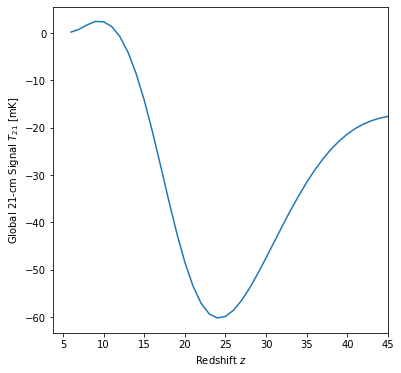

In [31]:
def plot_global_signal(t21_cubes):
    """  Ploting function for global signal """
    
    # Calculate the 21-cm global signal
    global_signal = [np.mean(t21_cubes[:,:,:,idx]) for idx in range(t21_cubes.shape[-1])]

    # Plotting 
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ZS_SIM, global_signal)
    ax.set_ylabel(r"Global 21-cm Signal $T_{\rm 21}$ [mK]")
    ax.set_xlabel(r"Redshift $z$")
    ax.set_xlim(xmax=45)  # To avoid the initial numerical errors at z = 50
    plt.show()
    plt.close(fig)

# Plot the global signal
plot_global_signal(our_t21_cubes)

We can also plot the spherically averaged power spectrum at a fixed wavevector e.g. $k = 0.1$ cMpc$^{-1}$

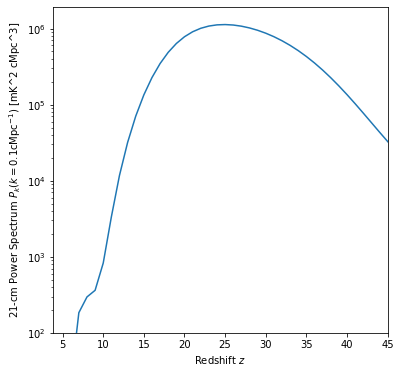

In [32]:
def spherically_averaged_power_spectrum(cube, k):
    """ Calculate spherically averaged power spectrum at a given value """
    # Full power spectrum
    full_power_spectrum = np.abs(scipy.fft.fftn(cube))**2 * (L_PIX)**6/(L_PIX*N_PIX)**3

    # Correponding ks
    ks_1d = [2*np.pi*scipy.fftpack.fftfreq(n_dim, d=L_PIX) for n_dim in full_power_spectrum.shape]
    kxs, kys, kzs = np.meshgrid(*ks_1d)
    ks = np.sqrt(kxs**2 + kys**2 + kzs**2)

    # Filter to required k band and average
    filter = np.bitwise_and(ks <= k*1.05, ks >= k*0.95)
    averaged_power_spectrum = np.sum(full_power_spectrum[filter]) / np.sum(filter)
    return averaged_power_spectrum


def plot_power_spectrum(t21_cubes, k = 0.1):
    """  Ploting function for spherically averaged power spectrum """
    
    # Calculate the 21-cm power spectrum
    power_spectrum = [spherically_averaged_power_spectrum(t21_cubes[:, :,:, idx], k) 
                      for idx in range(t21_cubes.shape[-1])]

    # Plotting 
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ZS_SIM, power_spectrum)
    ax.set_ylabel(r"21-cm Power Spectrum $P_k(k = 0.1{\rm cMpc}^{-1})$ [mK^2 cMpc^3]")
    ax.set_xlabel(r"Redshift $z$")
    ax.set_yscale("log")
    ax.set_xlim(xmax=45)  # To avoid the initial numerical errors at z = 50
    ax.set_ylim(ymin=1e2)
    plt.show()
    plt.close(fig)


# Plot the power spectrum
plot_power_spectrum(our_t21_cubes)

Here we only see the cosmic dawn peak, because we have not properly modelled the spatial distribution of reionization and X-ray heating, if we did we could see up to three peaks in the power spectrum.

Finally we can also look at slice of our simulated 21-cm cubes as well to see what tomographic 21-cm signal maps may look like

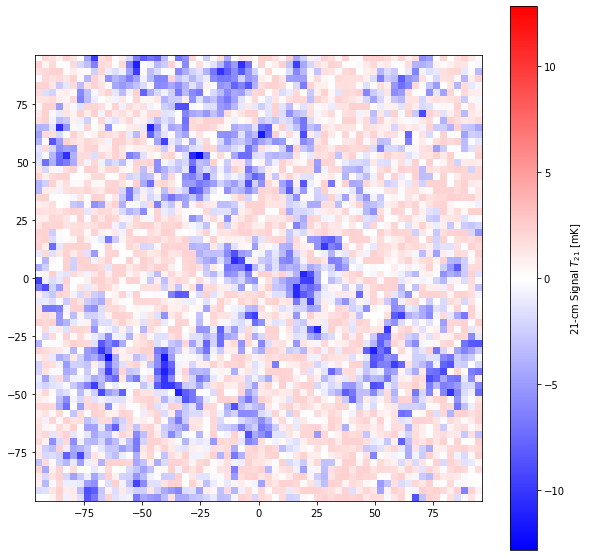

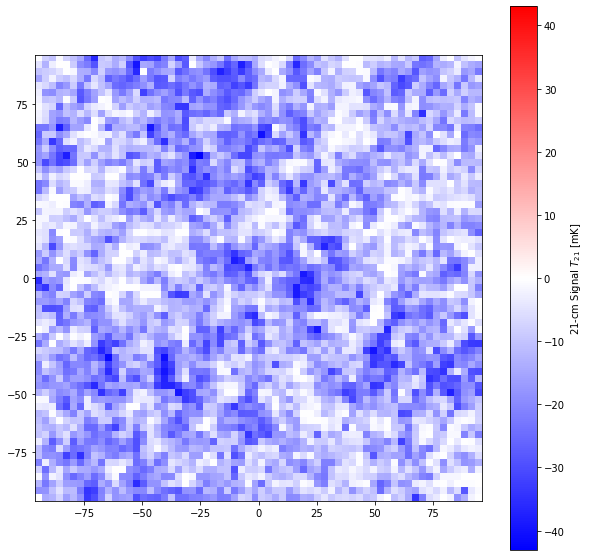

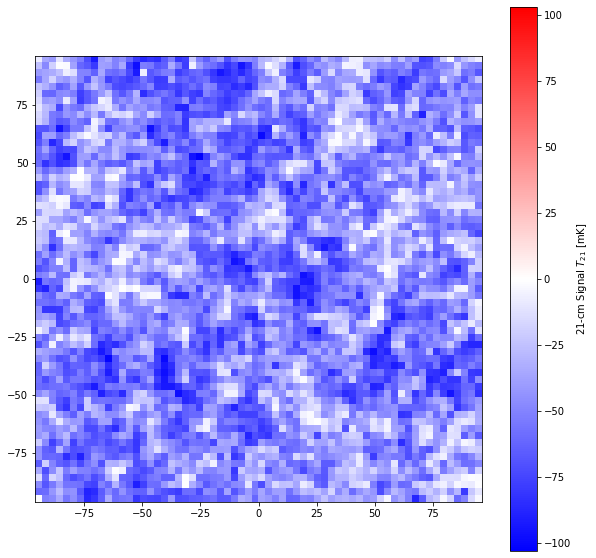

In [33]:
def plot_cubes_slice(t21_cube):
    """  Ploting function for 21-cm signal slices """
    
    t21_cube_slice = t21_cube[round(N_PIX/3), :, :]  # Arbitary choice of slice

    # Plotting 
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(t21_cube_slice, cmap='bwr', 
                      vmin=-np.max(np.abs(t21_cube_slice)), vmax=np.max(np.abs(t21_cube_slice)),
                      extent=[-N_PIX*L_PIX/2, N_PIX*L_PIX/2, -N_PIX*L_PIX/2, N_PIX*L_PIX/2])
    cbar = fig.colorbar(image, ax=ax, label=r'21-cm Signal $T_{\rm 21}$ [mK]')
    plt.show()
    plt.close(fig)

# Plot a slice at redshift 12
plot_cubes_slice(np.squeeze(our_t21_cubes[:, :, :, ZS_SIM==12]))

# Plot a slice at redshift 15
plot_cubes_slice(np.squeeze(our_t21_cubes[:, :, :, ZS_SIM==15]))

# Plot a slice at redshift 20
plot_cubes_slice(np.squeeze(our_t21_cubes[:, :, :, ZS_SIM==20]))

## 9. Exercises

Above you have seen how we built a simplified semi-numerical simulation. In this penultimate section you'll be given an opportunity to play with the simulation, trying different inputs, and time permitting have a go at extending it to add a new feature.

### 9.1 Parameter Dependance

Our simulation code takes four parameters
1. $f_{\rm star}$ the star formation efficiency of large dark matter halos
2. $\eta_{\rm Ly}$ the number of Lyman band photons emitted per unit stellar mass
3. $\eta_{\rm X-ray}$ the heat deposited per unit stellar mass 
4. $\eta_{\rm ion}$ the number of ionizing photons emitted per stellar mass

For which above we used fiducial values for these of
1. $f_{\rm star} = 0.05$
2. $\eta_{\rm Ly} = 3.59 \times 10^{61}$ photons M$_{\odot}^{-1}$
3. $\eta_{\rm X-ray} = 4.75 \times 10^{38}$ J M$_{\odot}^{-1}$
4. $\eta_{\rm ion} = 1.20 \times 10^{59}$ photons M$_{\odot}^{-1}$

But in reality the early universe remains fairly uncertain, and these parameters could still potentially be orders of magnitude different from the values given above. 

So, using our 21-cm signal simulation code explore how the 21-cm signal varies with each of the parameters. You will probably find it easiest to see the impacts by only varying one parameter at a time, and plotting the results alongside on the same axis as our initial simulation results. 

A space is provided for your investigation below (you can add more code and text blocks as you go too if you want to split up your investigation and make notes as you go)

In [34]:
# Hint:
# The syntax for running one of our simulations is
# output_t21_cubes = run_simulation(f_star, eta_lyman, eta_xray, eta_ion)
#
# You might also find the plot_global_signal function or at least its contents useful. 



### 9.2 Adding New Features

Now you have a feel for the simulations, and time permitting, why not have a go at adding a new feature to the code. Our semi-numerical simulation code is very simplified and so there is plenty of important physics that we do not include, such as baryon dark matter relative velocities, the LW feedback, the transition from Pop II to Pop III stars, or a proper modelling of ionization/X-ray heating propogation around sources. 

You are of course free to try and modify/added to any parts of the simulation you might want to. If you are looking for a suggestion of a upgrade that can be done in a shortish amount of time why not try to figure out how to extend `igm_heating_rate` to include the cooling due to the changing number of particles in the IGM as neutral hyrdrogen (1 independant free particle) is ionized into a proton and an electron (2 independant free particles). In terms of the maths that amounts to adding a new term to 
$$
\frac{dT_{\rm K}}{dz} = \frac{2 T_{\rm K}}{1 + z} + \frac{2}{3 k_{\rm B}(1 + x_{\rm e})}\frac{dt}{dz} \hat{\epsilon}_X,
$$
so that it is now
$$
\frac{dT_{\rm K}}{dz} = \frac{2 T_{\rm K}}{1 + z} + \frac{2}{3 k_{\rm B}(1 + x_{\rm e})}\frac{dt}{dz} \hat{\epsilon}_X - \frac{T_{\rm K}}{1 + x_{\rm e}}\frac{dx_e}{dz}.
$$


In [35]:
# Hint: 
# If you are going to try and impliment the suggestion you'll want to redefine 
# igm_heating_rate here, and use igm_ionization_rate to get the ionization rate


## 10. Concluding Remarks

In this workbook we have developed a simple semi-numerical simulation of the 21-cm signal, allowing us to produce predictions for the global 21-cm signal, power spectrum, and tomographic maps. If time allowed you have also got the oppurtunity to explore how the 21-cm signal varied with our four different parameters, and have a go at developing the code yourself adding new features. 

Hopefully you will afree that 21-cm semi numerical simulations are a powerful tool for producing predicitons of the 21-cm signal in reasonable (minutes to hours) time frame, and exploring how the signal is impacted by various pieces of physics. However, even for this simplified simulation we have runtimes for a single simulation of a few minutes, with full sized state-of-the-art simulations that inlcude more physics taking hours. This is prohibitivley long for performing the large number of simulations that are needed to constrain the uncertain properties of the early universe using actual data. 

So in the next session with Harry you will learn about neural networks, machine learning, and emulators, and see how these can be applied to produce excellent approximations to these full simulations that run in mear milliseconds. 



## 11. Acknowledgments

This workbook was written by Thomas Gessey-Jones (TODO link) for the DARA 2023 REACH workshop on radio cosmology as an educational tool for introducing semi-numerical 21-cm signal simulations. 

I would like to thank the organizers for given me the oppurtunity to present at this workshop, and finally giving me the motivation to make this workbook, something I have wanted to do for some time. 

The strucutre of this code is inspired by the private 21-cm signal simulation code developed over many years by Anastasia Fialkov, Rennan Barkana, Itamar Reis and others who have my sincerest thanks for giving me access to said code and teaching me how to use it and extend it. Several of the equations that are used have been modified from the original 21-cm FAST paper by Mesinger and others, which remains an excellent more technical introduction to 21-cm signal simulations. 

Finally I would like to thank Christian Kirkham for his testing of this workbook and his invaluable feedback. 

If you have any feedback on the workbook or would like to contribute to it feel free to contact me at tg400@cam.ac.uk or open a pull request on the Github repository where this workbook is hosted. 

# TODO List
3. Check all formula
4. Cite text
5. Review text
6. Code review 
7. Spellcheck
8. Figure text
9. Check plots
9. Intro to Google Colab
10. ctr+F TODO
11. Delete this 